Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762

C:\Users\alaa\AppData\Local\Temp\ipykernel_21004\3730501872.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='species', palette='rocket')


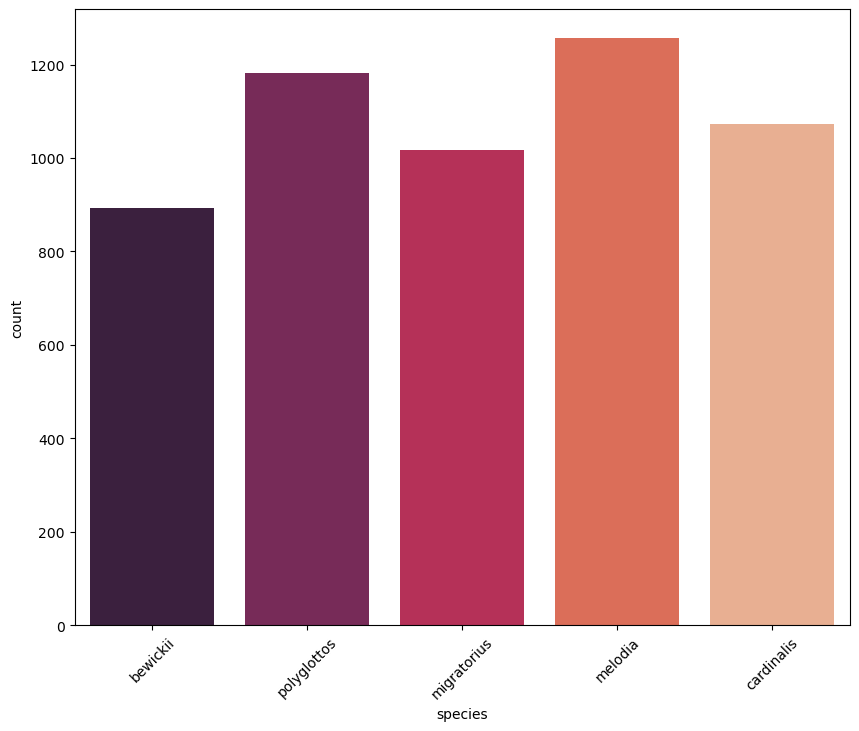

C:\Users\alaa\AppData\Local\Temp\ipykernel_21004\3730501872.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['species'] = df['species'].replace(species_dict)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - loss: 2.0948 - sparse_categorical_accuracy: 0.5798 - val_loss: 1.3582 - val_sparse_categorical_accuracy: 0.7174
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 1.3835 - sparse_categorical_accuracy: 0.5752 - val_loss: 0.9917 - val_sparse_categorical_accuracy: 0.7174
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.0553 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.8642 - val_sparse_categorical_accuracy: 0.8043
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.9079 - sparse_categorical_accuracy: 0.7765 - val_loss: 0.8042 - val_sparse_categorical_accuracy: 0.8043
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.8204 - sparse_categorical_accuracy: 0.8390 - val_loss: 0.7293 - val_sparse_categorical_accuracy: 0.8261
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.8493 - sparse_categorical_accuracy: 0.7664 - val_loss: 0.6871 - val_sparse_categorical_accuracy: 0.8261
Epoch 7/10
11/11

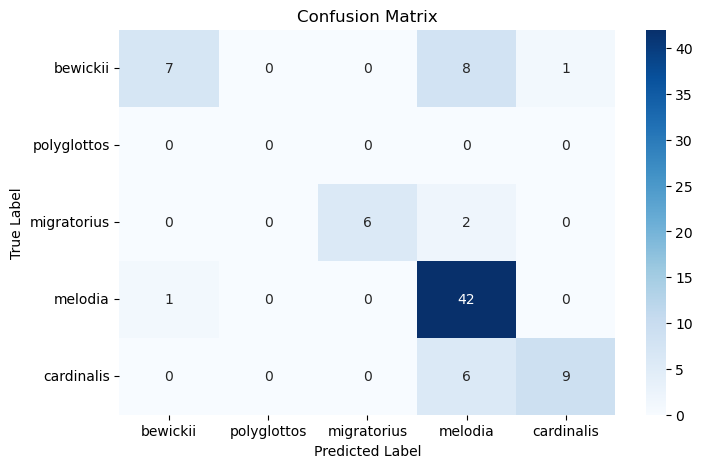

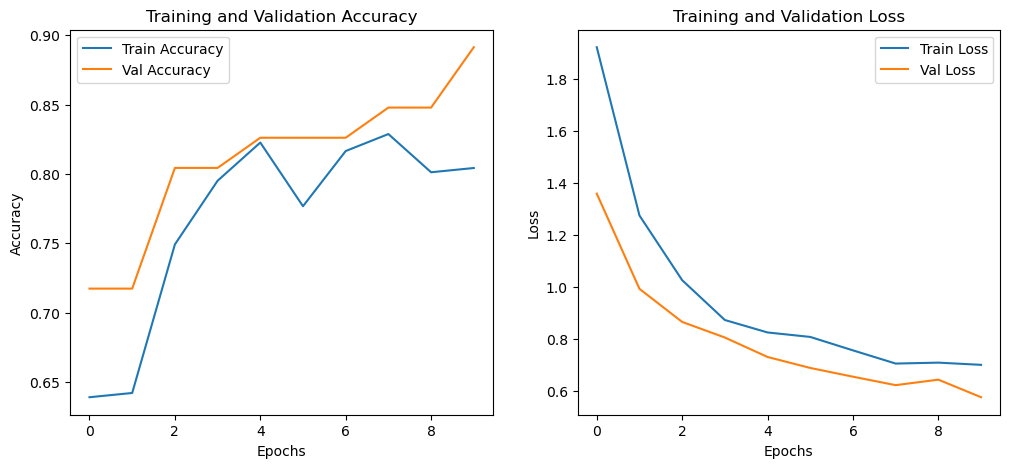

In [16]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import RandomFlip, RandomRotation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from scipy.io import wavfile

# Paths
wavefiles_dir = r"D:\Kaggle\wavfiles"
metadata_dir = r"D:\Kaggle\bird_songs_metadata.csv"

# Load Metadata
df = pd.read_csv(metadata_dir)
print("Metadata Info:")
print(df.info())
print(df['species'].value_counts())

# Visualize Species Distribution
plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='species', palette='rocket')
plt.xticks(rotation=45)
plt.show()

# Encode Labels
species_dict = {'bewickii': 0, 'polyglottos': 1, 'migratorius': 2, 'melodia': 3, 'cardinalis': 4}
df['species'] = df['species'].replace(species_dict)

# Filter out non-existent filenames
valid_filepaths = []
valid_labels = []

for filename, label in zip(df['filename'], df['species']):
    filepath = os.path.join(wavefiles_dir, filename)
    if os.path.exists(filepath):
        valid_filepaths.append(filepath)
        valid_labels.append(label)

# Now, valid_filepaths and valid_labels contain only the existing files and their corresponding labels
filepaths = np.array(valid_filepaths)
labels = np.array(valid_labels)

# Split Data
train_filepaths, val_filepaths, train_labels, val_labels = train_test_split(filepaths, labels, test_size=0.1, random_state=45)
train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(train_filepaths, train_labels, test_size=0.2, random_state=45)

# Function to Generate Spectrograms Without Librosa
def read_and_spec_file(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File {filepath} not found.")  # Custom error message
    sample_rate, audio = wavfile.read(filepath)
    audio = audio.astype(np.float32) / np.max(np.abs(audio))
    spectrogram = tf.signal.stft(audio, frame_length=512, frame_step=256, fft_length=512)
    spectrogram = tf.abs(spectrogram)
    spectrogram_db = tf.math.log(spectrogram + 1e-6)

    spec_tensor = tf.expand_dims(spectrogram_db, axis=-1)
    spec_resized = tf.image.resize(spec_tensor, (224, 224))
    spec_rgb = tf.image.grayscale_to_rgb(spec_resized)
    return spec_rgb.numpy()

# Map File Paths to Spectrograms
def map_file_to_spec(path_tensor, label):
    spec_rgb = tf.numpy_function(read_and_spec_file, inp=[path_tensor], Tout=tf.float32)
    spec_rgb.set_shape((224, 224, 3))
    return spec_rgb, label

# Create TensorFlow Dataset
def make_dataset(labels, filepaths, shuffle=True):
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    filepaths = tf.convert_to_tensor(filepaths, dtype=tf.string)

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(filepaths), reshuffle_each_iteration=True)
    dataset = dataset.map(map_file_to_spec, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = make_dataset(train_labels, train_filepaths, shuffle=True)
val_dataset = make_dataset(val_labels, val_filepaths, shuffle=False)
test_dataset = make_dataset(test_labels, test_filepaths, shuffle=False)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
])

def preprocess_and_augment(image, label):
    image = data_augmentation(image)
    return image, label

train_dataset = train_dataset.map(preprocess_and_augment)

# ResNet50 Model Creation
def create_resnet_model():
    inputs = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation="softmax")(x)

    return Model(inputs=inputs, outputs=outputs)

model = create_resnet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

# Callbacks
checkpoint_filepath = 'model_checkpoint/resnet50_model.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='tb_logs/resnet50_model')

# Train the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[model_checkpoint_callback, early_stopping, tensorboard_callback])

# Load Best Model and Evaluate
test_model = tf.keras.models.load_model(checkpoint_filepath)
test_results = test_model.evaluate(test_dataset)
print("Test Results:", test_results)

# Predictions
y_logits = test_model.predict(test_dataset)
y_pred = tf.argmax(y_logits, axis=1)
y_true = tf.concat(list(test_dataset.map(lambda x, lab: lab)), axis=0)

# Confusion Matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues',
            xticklabels=list(species_dict.keys()), yticklabels=list(species_dict.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# # Precision, Recall, and F1-Score
# report = classification_report(y_true, y_pred, target_names=species_dict.keys())
# print("Classification Report:\n", report)

# # ROC Curves and AUC
# y_true_onehot = to_categorical(y_true, num_classes=5)
# y_pred_prob = tf.nn.softmax(y_logits)
# plt.figure(figsize=(10, 8))
# for i, species in enumerate(species_dict.keys()):
#     fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves')
# plt.legend()
# plt.show()


In [18]:
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert y_true (which is a TensorFlow tensor) to a NumPy array
y_true_numpy = y_true.numpy()

# Ensure the number of unique classes in y_true is reflected in target_names
unique_classes = sorted(set(y_true_numpy))  # Get unique classes from y_true

# Adjust target_names dynamically based on the unique classes in y_true
target_names = [species for species in species_dict.keys() if species_dict[species] in unique_classes]

# Precision, Recall, and F1-Score
report = classification_report(y_true_numpy, y_pred, target_names=target_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    bewickii       0.88      0.44      0.58        16
 migratorius       1.00      0.75      0.86         8
     melodia       0.72      0.98      0.83        43
  cardinalis       0.90      0.60      0.72        15

    accuracy                           0.78        82
   macro avg       0.87      0.69      0.75        82
weighted avg       0.81      0.78      0.77        82



In [8]:
from tensorflow.keras.utils import to_categorical

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.7673 - sparse_categorical_accuracy: 0.7652
Test Results: [0.7314157485961914, 0.7804877758026123]
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


E:\Anconda\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


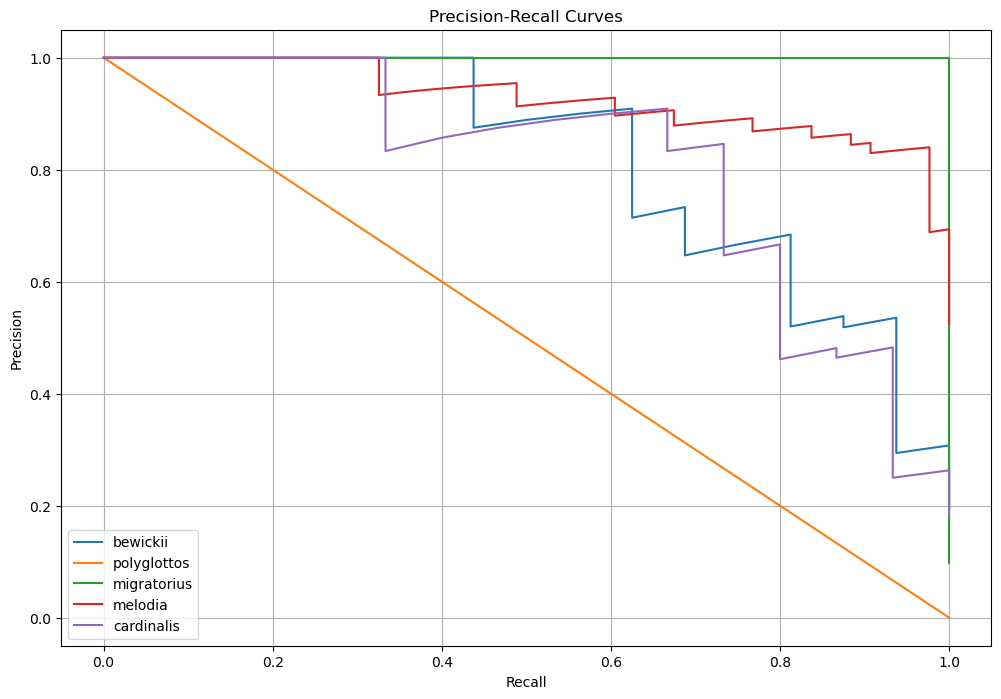

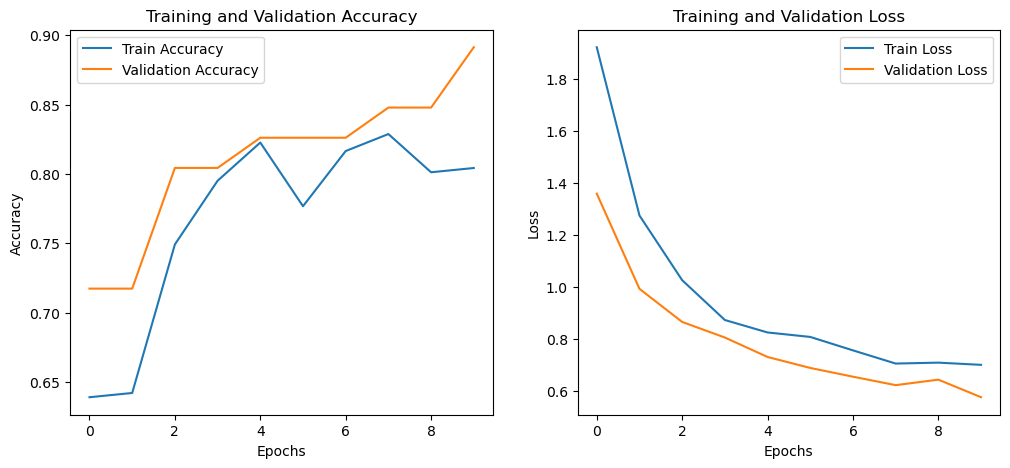

In [20]:
# Load Best Model and Evaluate
test_model = tf.keras.models.load_model(checkpoint_filepath)  # Ensure this line is executed before predictions
test_results = test_model.evaluate(test_dataset)
print("Test Results:", test_results)

# Predictions
y_logits = test_model.predict(test_dataset)
y_pred = tf.argmax(y_logits, axis=1).numpy()  # Convert to numpy array

# Extract true labels from the test dataset
y_true = tf.concat(list(test_dataset.map(lambda x, lab: lab)), axis=0).numpy()  # Convert to numpy array

# Ensure y_true_onehot and y_pred_prob are defined
y_true_onehot = to_categorical(y_true, num_classes=len(species_dict))  # One-hot encoding of true labels
y_pred_prob = tf.nn.softmax(y_logits).numpy()  # Convert logits to probabilities

# Precision, Recall, and F1-Score
# Precision-Recall Curve
plt.figure(figsize=(12, 8))
for i, species in enumerate(species_dict.keys()):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{species}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid()
plt.show()

# Training History Visualization
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()